In [233]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re
import math

In [234]:
# read file
df = pd.read_csv('ventas.csv')
# clean data
### format col names 
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df = df[['marca_temporal','dirección_de_correo_electrónico', '¿cuál_es_el_stock_id?',
         '¿cuál_es_tu_showroom/equipo?_[centro:]']]
df = df.rename(columns={'marca_temporal': 'date', 'dirección_de_correo_electrónico':'name', 
                                      '¿cuál_es_el_stock_id?':'stockid', 
                        '¿cuál_es_tu_showroom/equipo?_[centro:]':'hub'})
# exclude financers
excluir = ['christopher.arias@kavak.com', 'jose.nava@kavak.com','rosela.ortega@kavak.com']
df = df.loc[-(df['name'].isin(excluir))]
# examine data
print(df.shape)
df.tail(10)

(478, 4)


,date,name,stockid,hub
528,23/11/2020 13:32:26,juan.sanchez@kavak.com,24681.0,Kavak 360
542,25/11/2020 12:24:14,victor.cuellar@kavak.com,22193.0,Florencia
543,25/11/2020 13:11:13,cristopher.navarrete@kavak.com,23857.0,Fortuna
544,25/11/2020 17:06:16,cristopher.navarrete@kavak.com,24900.0,Fortuna
545,25/11/2020 17:08:40,cristopher.navarrete@kavak.com,23766.0,Fortuna
546,NaN,NaN,NaN,NaN
547,NaN,NaN,NaN,NaN
548,NaN,NaN,NaN,NaN
549,NaN,NaN,NaN,NaN
550,NaN,NaN,NaN,NaN


In [235]:
# exclude empty rows
df = df[0:473]
# examine data
print(df.shape)
df.tail(10)

(473, 4)


,date,name,stockid,hub
523,21/11/2020 16:28:52,francisco.robles@kavak.com,24350.0,Florencia
524,21/11/2020 18:07:36,luis.benitez@kavak.com,22400.0,Santa Fe
525,21/11/2020 18:10:27,luis.benitez@kavak.com,23940.0,Santa Fe
526,21/11/2020 18:34:28,samuel.tellez@kavak.com,25625.0,Fortuna
527,21/11/2020 19:04:07,gustavo.perez@kavak.com,24200.0,San Angel
528,23/11/2020 13:32:26,juan.sanchez@kavak.com,24681.0,Kavak 360
542,25/11/2020 12:24:14,victor.cuellar@kavak.com,22193.0,Florencia
543,25/11/2020 13:11:13,cristopher.navarrete@kavak.com,23857.0,Fortuna
544,25/11/2020 17:06:16,cristopher.navarrete@kavak.com,24900.0,Fortuna
545,25/11/2020 17:08:40,cristopher.navarrete@kavak.com,23766.0,Fortuna


In [236]:
### create name col
def extr_name(email):
    name, last = re.findall('[a-z]+', email)[0:2]
    full = str(name).capitalize() + " " + str(last).capitalize()
    return full
df['name'] = df['name'].apply(extr_name)
### format and sort by date col
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.sort_values('date')
### add month and year cols
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
# filter by and format stockid
df = df.drop_duplicates(['stockid'])
df['stockid'] = df['stockid'].astype(int)
# examine data
print(df.shape)
df.head(10)

(454, 6)


,date,name,stockid,hub,month,year
0,2020-02-28 15:49:25,Nestor Huerta,123456,Kavak 360,2,2020
1,2020-02-28 16:01:45,Nestor Huerta,12345678,Entregas casa cliente,2,2020
2,2020-03-04 10:40:00,Nestor Huerta,224477,Entregas casa cliente,3,2020
3,2020-03-04 11:29:00,Nestor Huerta,1256,Florencia,3,2020
4,2020-03-04 11:37:00,Nestor Huerta,12345,Fortuna,3,2020
5,2020-03-04 12:00:00,Nestor Huerta,1234,Lerma,3,2020
6,2020-03-05 09:30:00,Juan Vazquez,3999,Santa Fe,3,2020
7,2020-03-05 16:49:00,Nayeli Lopez,17787,Fortuna,3,2020
8,2020-03-05 18:42:00,Carlos Beto,13612,Santa Fe,3,2020
9,2020-03-05 18:43:00,Carlos Beto,19052,Santa Fe,3,2020


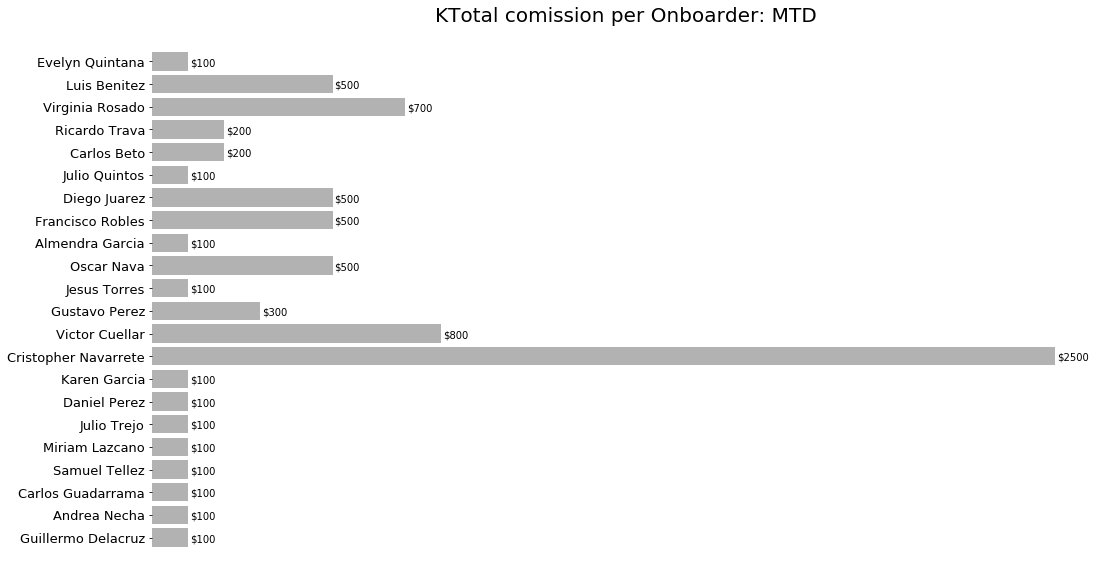

In [240]:
# graph 1: MTD
### find curr month and year
curr_month = pd.to_datetime(datetime.date(datetime.now())).month
curr_year = pd.to_datetime(datetime.date(datetime.now())).year
### include only curr month
df_curm = df[(df['month'] == curr_month) & (df['year'] == curr_year)]
### initialize dic
mkavakos = {}
### count sales per onboarder
for kavako, frame in df_curm.groupby(['name']):
    mkavakos[kavako] = len(frame)
if ('Juan Sanchez' in mkavakos.keys()):
    mkavakos.pop('Juan Sanchez')
# plot figure
fig, ax = plt.subplots(1,1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(17)
bar1 = ax.barh(mkavakos.keys(), mkavakos.values(), alpha=.6, color='gray')
# format axes, title, and labels
### axes
for loc in ('right', 'top', 'left', 'bottom'):
    ax.spines[loc].set_visible(False)
ax.set_xticks([]);
ax.set_yticklabels(mkavakos.keys(), fontsize=13)
### title
ax.set_title('KTotal comissions per Onboarder: MTD', fontsize=20)
### labels
for idx,rect in enumerate(bar1):
    ax.text(mkavakos.values()[idx]+.05, rect.get_y()+.35,
            "${}".format(mkavakos.values()[idx]*100), fontsize=10,
            ha='left', va='center', rotation=0)
# save fig
plt.savefig('onboarder_performance_mtd.png');

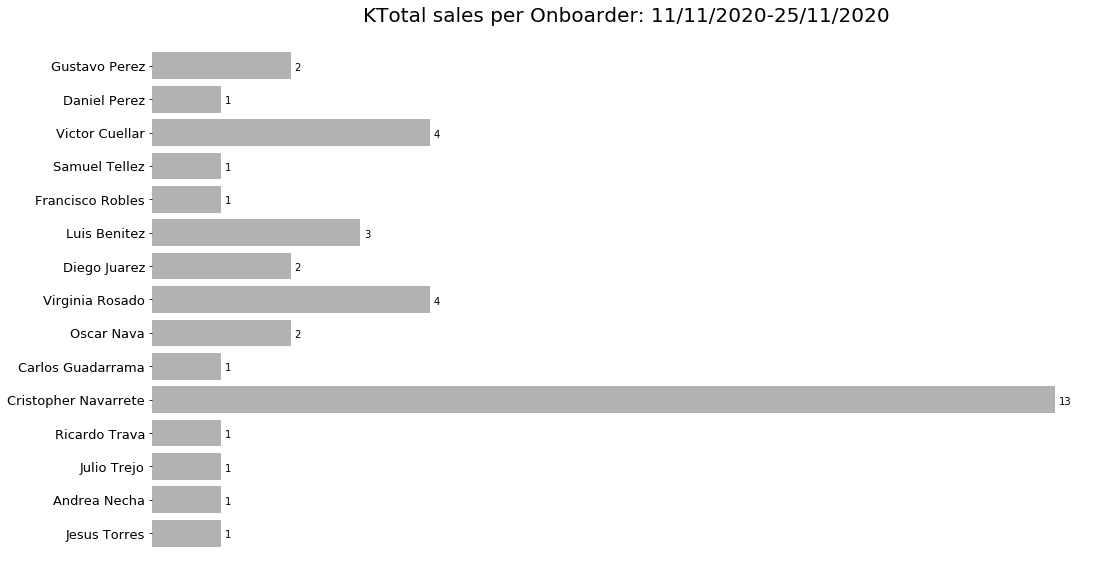

In [239]:
# graph 1: past 15 days
### find last 15 days
ayer = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=1))
hace_quince = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=15))
### include only curr month
df_curd = df[df['date'] >= hace_quince]
### initialize dic
### count sales per onboarder
for kavako, frame in df_curd.groupby(['name']):
    dkavakos[kavako] = len(frame)
if ('Juan Sanchez' in dkavakos.keys()):
    dkavakos.pop('Juan Sanchez')
# plot figure
fig2, ax2 = plt.subplots(1,1, sharex=True)
fig2.set_figheight(10)
fig2.set_figwidth(17)
bar2 = ax2.barh(dkavakos.keys(), dkavakos.values(), alpha=.6, color='gray')
# format axes, title, and labels
### axes
for loc in ('right', 'top', 'left', 'bottom'):
    ax2.spines[loc].set_visible(False)
ax2.set_xticks([]);
ax2.set_yticklabels(dkavakos.keys(), fontsize=13)
### title
titlestr = ('KTotal sales per Onboarder: ' + hace_quince.strftime('%d/%m/%Y') + '-' + 
           ayer.strftime('%d/%m/%Y'))
ax2.set_title(titlestr, fontsize=20)
### labels
for idx,rect in enumerate(bar2):
    ax2.text(dkavakos.values()[idx]+.05, rect.get_y()+.35,
            dkavakos.values()[idx], fontsize=10,
            ha='left', va='center', rotation=0)
# save fig
plt.savefig('onboarder_performance_15d.png');